In [30]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Color palette (accessible, high-contrast)
COLOR_YES = '#1f77b4'   # blue
COLOR_NO =  '#ff7f0e'   # orange
COLOR_NF =  '#2ca02c'   # green

PREPROCESSED_NAME = 'preprocessed_files'
PREFIX = 'rsg_'
SUFFIX = '_preprocessed.csv'

# Locate Data directory by searching upward

def find_data_dir(start=None):
    start = Path.cwd() if start is None else Path(start)
    for base in [start] + list(start.parents):
        candidate = base / 'Data'
        if candidate.exists() and candidate.is_dir():
            return candidate
    raise FileNotFoundError("Could not locate 'Data' directory.")

DATA_DIR = find_data_dir()
print(f"Using Data directory: {DATA_DIR}")

# Discover preprocessed files

def find_preprocessed_files(data_dir: Path) -> list[Path]:
    results = []
    for period_dir in sorted([p for p in data_dir.iterdir() if p.is_dir()]):
        pre_dir = period_dir / PREPROCESSED_NAME
        if not pre_dir.exists():
            continue
        results += [f for f in pre_dir.iterdir() if f.is_file() and f.name.startswith(PREFIX) and f.name.endswith(SUFFIX)]
    return results

files = find_preprocessed_files(DATA_DIR)
len(files)


Using Data directory: c:\Users\Administrator\Desktop\projects\dric_publications_classification\Data


8

In [31]:
# Load and combine all preprocessed rows
frames = []
for f in files:
    try:
        df = pd.read_csv(f)
        df['__source_file'] = f
        frames.append(df)
    except Exception as e:
        print(f"Skipping {f}: {e}")

if not frames:
    raise RuntimeError('No preprocessed files loaded.')

df_all = pd.concat(frames, ignore_index=True)
# Normalize columns
if 'dric' in df_all.columns:
    df_all['dric'] = df_all['dric'].astype(str).str.upper().str.strip()
if 'year' in df_all.columns:
    df_all['year'] = pd.to_numeric(df_all['year'], errors='coerce').astype('Int64')

df_all.head(3)


,authors,title,year,dric,__source_file
0,"(1) AO Andrew Huzortey, Benjamin Anderson",Designed and Developed Low Cost Raman Spectros...,2016,NF,c:\Users\Administrator\Desktop\projects\dric_p...
1,"(1) P Osei-Kuffour, SB Kendie, KA Boakye","Conflict, peace and development: A spatio-them...",2016,NO,c:\Users\Administrator\Desktop\projects\dric_p...
2,"(2) AT Asare, E Asare-Bediako, F Agyarko, K Ta...",Phenotypic traits detect genetic variability i...,2016,YES,c:\Users\Administrator\Desktop\projects\dric_p...


In [32]:
# Simple author parsing: split on commas and ' and '
# Notes:
# - Authors field varies; we keep it simple and robust.
# - Remove leading counts like "(3) "

import re

def split_authors(authors_str: str) -> list[str]:
    if not isinstance(authors_str, str):
        return []
    s = authors_str.strip()
    # Remove leading counts e.g. "(3) "
    s = re.sub(r'^\(\d+\)\s*', '', s)
    # Normalize separators: handle ' and ' as comma
    s = s.replace(' and ', ', ')
    # Some entries have trailing ellipses or extra punctuation; keep minimal cleanup
    parts = [p.strip() for p in s.split(',') if p.strip()]
    return parts

# Explode to one row per author for YES only
if not {'authors','dric'}.issubset(df_all.columns):
    raise RuntimeError("Expected columns 'authors' and 'dric' not found.")

df_yes = df_all[df_all['dric'] == 'YES'].copy()
df_yes['author_list'] = df_yes['authors'].apply(split_authors)
df_auth = df_yes.explode('author_list').rename(columns={'author_list':'author'})
df_auth = df_auth.dropna(subset=['author'])

df_auth.head(5)


,authors,title,year,dric,__source_file,author
2,"(2) AT Asare, E Asare-Bediako, F Agyarko, K Ta...",Phenotypic traits detect genetic variability i...,2016,YES,c:\Users\Administrator\Desktop\projects\dric_p...,AT Asare
2,"(2) AT Asare, E Asare-Bediako, F Agyarko, K Ta...",Phenotypic traits detect genetic variability i...,2016,YES,c:\Users\Administrator\Desktop\projects\dric_p...,E Asare-Bediako
2,"(2) AT Asare, E Asare-Bediako, F Agyarko, K Ta...",Phenotypic traits detect genetic variability i...,2016,YES,c:\Users\Administrator\Desktop\projects\dric_p...,F Agyarko
2,"(2) AT Asare, E Asare-Bediako, F Agyarko, K Ta...",Phenotypic traits detect genetic variability i...,2016,YES,c:\Users\Administrator\Desktop\projects\dric_p...,K Taah
2,"(2) AT Asare, E Asare-Bediako, F Agyarko, K Ta...",Phenotypic traits detect genetic variability i...,2016,YES,c:\Users\Administrator\Desktop\projects\dric_p...,EO Osei


In [33]:
# Deduplicate by (authors, title, year) after light normalization
import re

def _normalize_authors(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = re.sub(r'^\(\d+\)\s*', '', s)  # remove leading counts like "(3) "
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

def _normalize_title(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

if not {'authors','title','year'}.issubset(df_all.columns):
    raise RuntimeError("Expected columns 'authors', 'title', 'year' not found for deduplication.")

_before = len(df_all)

df_all['__authors_key'] = df_all['authors'].apply(_normalize_authors)
df_all['__title_key'] = df_all['title'].apply(_normalize_title)
df_all['__year_key'] = pd.to_numeric(df_all['year'], errors='coerce').astype('Int64')

df_all = df_all.drop_duplicates(subset=['__authors_key','__title_key','__year_key']).reset_index(drop=True)

_after = len(df_all)
print(f"Deduplicated by (authors,title,year): {_before} -> {_after} (removed {_before - _after})")

# Clean up helper columns (optional to keep for debugging)
df_all = df_all.drop(columns=['__authors_key','__title_key','__year_key'])


Deduplicated by (authors,title,year): 1034 -> 998 (removed 36)


In [34]:
# Overall top authors by YES count
overall_top = (df_auth.groupby('author').size().sort_values(ascending=False)).head(20)
overall_top_df = overall_top.reset_index(name='YES_count')
overall_top_df


,author,YES_count
0,...,14
1,PA Asare,5
2,EE Abano,3
3,F Kumi,3
4,IT Commey,3
5,SA Abraham,3
6,JPK Ninnoni,3
7,KK Amoah,3
8,D Obiri-Yeboah,3
9,D Miezah,2


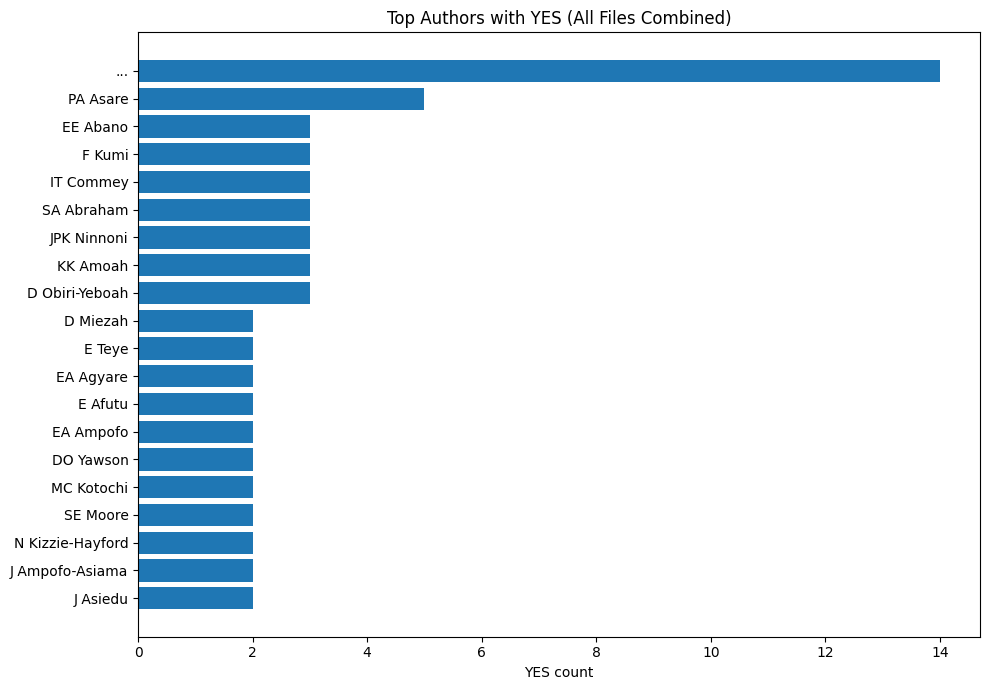

In [35]:
# Bar chart for overall top authors
plt.figure(figsize=(10, max(4, 0.35*len(overall_top_df))))
plt.barh(overall_top_df['author'][::-1], overall_top_df['YES_count'][::-1], color=COLOR_YES)
plt.xlabel('YES count')
plt.title('Top Authors with YES (All Files Combined)')
plt.tight_layout()
plt.show()


In [36]:
# Top authors with YES per year
df_auth_year = df_auth.dropna(subset=['year']).copy()

# For each year, get top N authors
TOP_N = 10
per_year_top = {}
for y, g in df_auth_year.groupby('year'):
    top = g.groupby('author').size().sort_values(ascending=False).head(TOP_N)
    per_year_top[int(y)] = top.reset_index(name='YES_count')

# Display table for most recent 5 years (if available)
recent_years = sorted(per_year_top.keys())[-5:]
for y in recent_years:
    print(f"Year {y} – Top {TOP_N} authors by YES")
    display(per_year_top[y])


Year 2018 – Top 10 authors by YES


,author,YES_count
0,...,1
1,D Obiri-Yeboah,1
2,E Obboh,1
3,F Pappoe,1
4,J Adu,1
5,P Nsiah,1
6,Y Asante Awuku,1


Year 2019 – Top 10 authors by YES


,author,YES_count
0,...,1
1,AH Benjamin,1
2,C Asiedu,1
3,D Obiri-Yeboah,1
4,E Obboh,1
5,G Adjei,1
6,KA Pereko,1
7,NI Ebu,1
8,O Cudjoe,1
9,S Akaba,1


Year 2021 – Top 10 authors by YES


,author,YES_count
0,...,3
1,A Twum,1
2,B Kyei-Asante,1
3,C Kyereme,1
4,D Obiri-Yeboah,1
5,D Sakyi-Arthur,1
6,DO Yawson,1
7,E Afutu,1
8,E Agyare,1
9,Ernest Obese,1


Year 2022 – Top 10 authors by YES


,author,YES_count
0,EE Abano,2
1,...,1
2,DO Yawson,1
3,E Afutu,1
4,EA Ampofo,1
5,F Kumi,1
6,G Anyebuno,1
7,IT Commey,1
8,J Akanson,1
9,J Ampofo-Asiama,1


Year 2023 – Top 10 authors by YES


,author,YES_count
0,...,8
1,PA Asare,3
2,D Miezah,2
3,CLY Amuah,2
4,E Teye,2
5,E Arthur,2
6,DA Tuoyire,2
7,EA Agyare,2
8,F Kumi,2
9,PB Obour,2


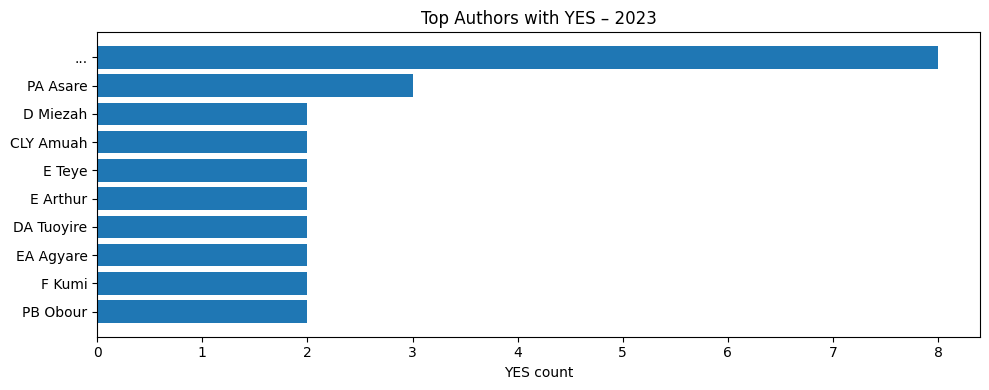

In [37]:
# Example chart: Top authors for the most recent year (if available)
if per_year_top:
    most_recent = max(per_year_top.keys())
    top_df = per_year_top[most_recent]
    plt.figure(figsize=(10, max(4, 0.35*len(top_df))))
    plt.barh(top_df['author'][::-1], top_df['YES_count'][::-1], color=COLOR_YES)
    plt.xlabel('YES count')
    plt.title(f'Top Authors with YES – {most_recent}')
    plt.tight_layout()
    plt.show()
else:
    print('No per-year data available.')


In [38]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Make plots inline
%matplotlib inline

PREPROCESSED_NAME = 'preprocessed_files'
PREFIX = 'rsg_'
SUFFIX = '_preprocessed.csv'

def find_data_dir(start=None):
    start = Path.cwd() if start is None else Path(start)
    for base in [start] + list(start.parents):
        candidate = base / 'Data'
        if candidate.exists() and candidate.is_dir():
            return candidate
    raise FileNotFoundError("Could not locate 'Data' directory from this notebook's working directory or its parents.")

DATA_DIR = find_data_dir()
print(f"Using Data directory: {DATA_DIR}")

def find_preprocessed_files(data_dir: Path) -> list[tuple[str, Path]]:
    """Return list of (period, file_path) for all rsg_<period>_preprocessed.csv under Data/<period>/preprocessed_files.
    Skips non-directories and periods without the expected file.
    """
    results: list[tuple[str, Path]] = []
    for period_dir in sorted([p for p in data_dir.iterdir() if p.is_dir()]):
        pre_dir = period_dir / PREPROCESSED_NAME
        if not pre_dir.exists():
            continue
        for f in pre_dir.iterdir():
            if f.is_file() and f.name.startswith(PREFIX) and f.name.endswith(SUFFIX):
                results.append((period_dir.name, f))
    return results

files = find_preprocessed_files(DATA_DIR)
files


Using Data directory: c:\Users\Administrator\Desktop\projects\dric_publications_classification\Data


[('2015-2016',
  WindowsPath('c:/Users/Administrator/Desktop/projects/dric_publications_classification/Data/2015-2016/preprocessed_files/rsg_2015-2016_preprocessed.csv')),
 ('2016-2017',
  WindowsPath('c:/Users/Administrator/Desktop/projects/dric_publications_classification/Data/2016-2017/preprocessed_files/rsg_2016-2017_preprocessed.csv')),
 ('2017-2018',
  WindowsPath('c:/Users/Administrator/Desktop/projects/dric_publications_classification/Data/2017-2018/preprocessed_files/rsg_2017-2018_preprocessed.csv')),
 ('2018-2019',
  WindowsPath('c:/Users/Administrator/Desktop/projects/dric_publications_classification/Data/2018-2019/preprocessed_files/rsg_2018-2019_preprocessed.csv')),
 ('2020',
  WindowsPath('c:/Users/Administrator/Desktop/projects/dric_publications_classification/Data/2020/preprocessed_files/rsg_2020_preprocessed.csv')),
 ('2021',
  WindowsPath('c:/Users/Administrator/Desktop/projects/dric_publications_classification/Data/2021/preprocessed_files/rsg_2021_preprocessed.csv'))

In [39]:
from collections import Counter

per_period_counts: dict[str, Counter] = {}
all_counts = Counter()

for period, path in files:
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"Skipping {path}: {e}")
        continue
    if 'dric' not in df.columns:
        print(f"Skipping {path}: missing 'dric' column")
        continue
    counts = Counter([str(x).strip().upper() for x in df['dric'].dropna().tolist()])
    per_period_counts[period] = counts
    all_counts.update(counts)

per_period_counts, all_counts


({'2015-2016': Counter({'NO': 11, 'NF': 3, 'YES': 1}),
  '2016-2017': Counter({'NO': 49, 'NF': 19}),
  '2017-2018': Counter({'NO': 18, 'NF': 11}),
  '2018-2019': Counter({'NO': 111, 'NF': 28, 'YES': 3}),
  '2020': Counter({'NO': 107, 'NF': 24}),
  '2021': Counter({'NO': 132, 'NF': 24, 'YES': 6}),
  '2022': Counter({'NO': 174, 'NF': 18, 'YES': 4}),
  '2023': Counter({'NO': 237, 'NF': 39, 'YES': 15})},
 Counter({'NO': 839, 'NF': 166, 'YES': 29}))

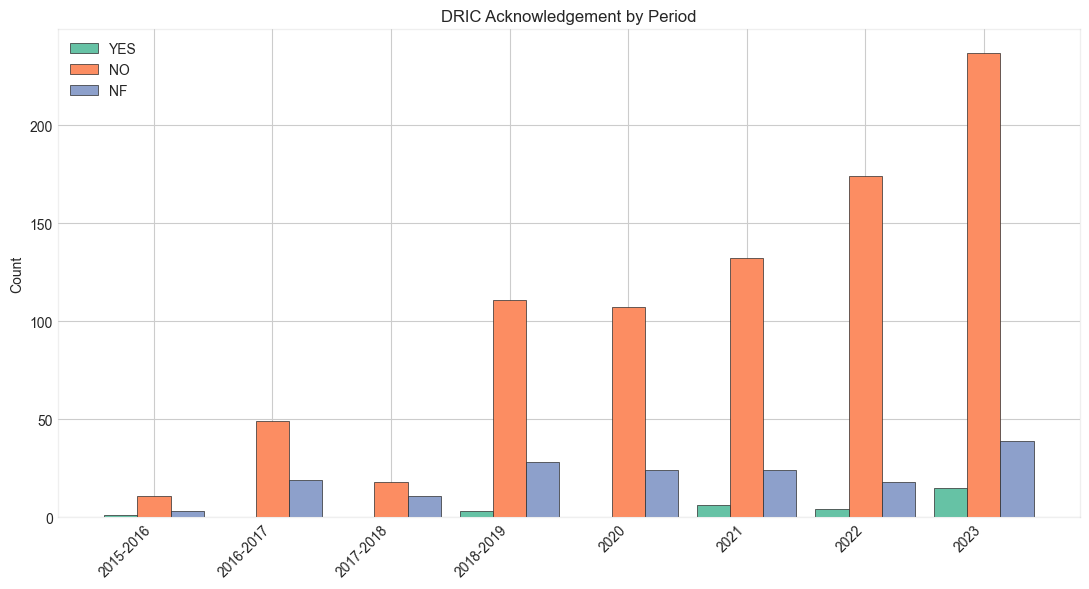

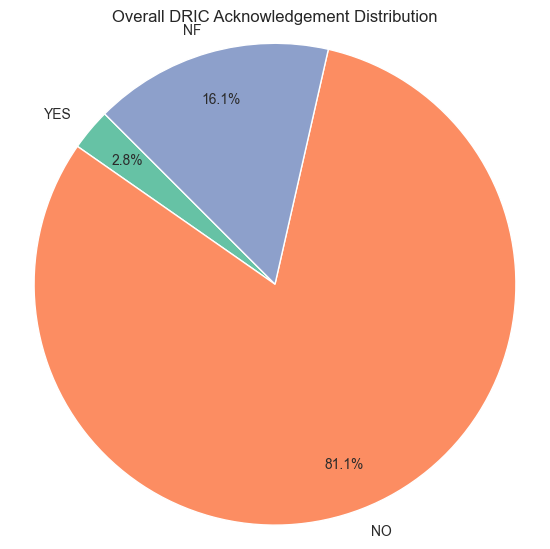

In [40]:
import numpy as np
import matplotlib as mpl

# Modern, colorblind-friendly styling
plt.style.use('seaborn-v0_8-whitegrid')
CATS = ['YES', 'NO', 'NF']
PALETTE = {
    'YES': '#66c2a5',  # Set2 green/teal
    'NO':  '#fc8d62',  # Set2 orange
    'NF':  '#8da0cb',  # Set2 purple/blue
}

periods = sorted(per_period_counts.keys())
yes_vals = [per_period_counts.get(p, {}).get('YES', 0) for p in periods]
no_vals = [per_period_counts.get(p, {}).get('NO', 0) for p in periods]
nf_vals = [per_period_counts.get(p, {}).get('NF', 0) for p in periods]

x = np.arange(len(periods))
width = 0.28

# Grouped bars with improved aesthetics
plt.figure(figsize=(max(11, len(periods)*0.9), 6))
plt.bar(x - width, yes_vals, width, label='YES', color=PALETTE['YES'], edgecolor='#2b2b2b', linewidth=0.5)
plt.bar(x,         no_vals,  width, label='NO',  color=PALETTE['NO'],  edgecolor='#2b2b2b', linewidth=0.5)
plt.bar(x + width, nf_vals,  width, label='NF',  color=PALETTE['NF'],  edgecolor='#2b2b2b', linewidth=0.5)
plt.xticks(x, periods, rotation=45, ha='right')
plt.ylabel('Count')
plt.title('DRIC Acknowledgement by Period')
for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Overall totals pie chart with cleaner look
overall_vals = [all_counts.get(c, 0) for c in CATS]
plt.figure(figsize=(5.6, 5.6))
plt.pie(
    overall_vals,
    labels=CATS,
    autopct='%1.1f%%',
    startangle=135,
    colors=[PALETTE[c] for c in CATS],
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    pctdistance=0.8,
    textprops={'color': '#2b2b2b'}
)
plt.title('Overall DRIC Acknowledgement Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()
